In [1]:
from networkx import grid_graph
import networkx as nx
import numpy as np
import random
from matplotlib import colors, cm
import matplotlib.pyplot as plt
#%matplotlib qt
from time import sleep
import matplotlib.animation as animation
from dendropy.calculate import treemeasure
from dendropy import Tree as DTree
from io import StringIO
from random import sample, random, choice
from copy import deepcopy
from math import log
from matplotlib.animation import PillowWriter
from ete3 import Tree, NodeStyle, TreeStyle
import tqdm
from Bio import Phylo
from plot_eteTree import plot_tree
from collections import Counter
import pandas as pd
# Takes a genotype and converts it to an integer for use indexing the fitness landscape list 
def convertGenotypeToInt(genotype):
	out = 0
	for bit in genotype:
		out = (out << 1) | bit
	return out

# Converts an integer to a genotype by taking the binary value and padding to the left by 0s		
def convertIntToGenotype(anInt, pad):
	offset = 2**pad
	return [int(x) for x in bin(offset+anInt)[3:]]	

def flip(allele):
    if allele ==1:
        allele = 0
    else:
        allele =1
        
    return allele



In [381]:

# def deathprob(d,m,s, p0,n): 
#     y= (1/(1+p0))*(d**n/(d**n+(s*m)+1)+p0)
#     return y

def deathprob(d,m,s, p,n,): 
    y= (a-s)*(d**n/(d**n+(b*m)*((s+a)/s))) +s
    return y


# def birthprob(m,mh,b0,b_inf,n): 
#     y = (b0-b_inf)*(mh/((m)**n+mh))+b_inf
#     return y 


def birthprob(m,mh,b0,b_inf,n): 
    y = b0
    return y 


def sort_pairs(pair):
    # Extract integer after "r".
    return int(pair[0][1:])
   
def make_tree_from_list(mut_pairs):
    parents = []
    children = []
    pairs_of_mutations = []
    for item in mut_pairs:
        a = 'r'+str(item[0])
        b = 'r'+str(item[1])
        pairs_of_mutations.append((a,b))
    t = Tree() # Creates an empty tree
    r0 = t.add_child(name="r0")
    lookup = {"r0": r0}

    for pair in sorted(pairs_of_mutations, key=sort_pairs):
        parentname = pair[0]
        childname = pair[1]
        if childname not in lookup:
            if parentname in lookup:
                newchild = lookup[parentname].add_child(name = childname)
                lookup.update({childname: newchild})

                parents.append(parentname) #make list of unique terminal nodes (no children of children)
                children.append(newchild)
            else:
                print(pair)
                raise RuntimeError('Must not happen.')

    return t

def make_pruned_tree_from_list(mut_pairs):
    parents = []
    children = []
    pairs_of_mutations = []
    for item in mut_pairs:
        a = 'r'+str(item[0])
        b = 'r'+str(item[1])
        pairs_of_mutations.append((a,b))
    t = Tree() # Creates an empty tree
    r0 = t.add_child(name="r0")
    lookup = {"r0": r0}
    prune_list = ['r0']
    for pair in sorted(pairs_of_mutations, key=sort_pairs):
        parentname = pair[0]
        childname = pair[1]
        if childname not in lookup:
            if parentname in lookup:
                newchild = lookup[parentname].add_child(name = childname)
                lookup.update({childname: newchild})
                if parentname not in parents:
                    prune_list.append(lookup[parentname])
                parents.append(parentname) #make list of unique terminal nodes (no children of children)
                children.append(newchild)
            else:
                print(pair)
                raise RuntimeError('Must not happen.')
    prune_count = Counter(children)
    t.prune(prune_list)
    return t


In [382]:
def sim_for_tree(wt,ln, g,mut_rate, s,p0,n,mh,b0,b_inf, n1):
    
    width = wt
    length = ln
    grid_size = g
    
    ##setup nx graph to find neibors quickly
    G = grid_graph(dim=[wt, ln])
    
    ##set up grid to keep track of cell state i.e. number of mutations
    cells = np.full((ln,wt),-1)
    cells[0] = 0 
    
    ##set up grid to keep track of cell state i.e. number of mutations
    muts = np.full((ln,wt),-1)
    muts[0] = 0 
    
    
    
    ##set up grid that maps abx conc.  to space
    l = [val for sublist in [[j for i in range(int(ln/grid_size))] for j in range (0,5)] for val in sublist]
    ab =[[3*10**(i-1)]*wt for i  in l if i != 0]
    [ab.insert(i, [0]*wt) for i in range(0,int(ln/grid_size))]
    ab = np.array(ab)
    
    cell_history = []
    mut_pairs = []
    
    ##begin evolution
    while all(cells[-1] == -1):
        
        ## save current state map to list
        cell_history.append(cells.tolist())
        
        
        ##find slots where there is a living cells
        cells_where =  np.where(cells != -1)
        
        
        ##create a randomized list of the living cells with which to iterate through
        cells_list = []
        for x, y in zip(cells_where[0], cells_where[1]):
            cells_list.append([x,y])
            
        np.random.shuffle(cells_list)
        
        ##decide if each living in this generation will die, live, or mutate
        for j in cells_list: 
            d_draw, b_draw  = [random(),random()]
            
            ##death
            if deathprob(ab[tuple(j)],cells[tuple(j)],s, p0,n) > d_draw:
                cells[tuple(j)] == -1
                
            #mutate
            else:
                m = np.random.poisson(mut_rate)
                if m != 0:
                    cells[tuple(j)] = cells[tuple(j)]+m
                    muts[tuple(j)] = muts[tuple(j)] +1
                    muts_pairs.append(muts[tuple(j)],muts[tuple(j)]+1)
             
            #birth
                if birthprob(cells[tuple(j)],mh,b0,b_inf,n) > b_draw:
                
                    neighbors = [x for x in G.neighbors(tuple(j))]

                    #find which of the neighboring cells are empty, and divide, with a daughter cell in that space
                    empty = np.where(-1 == np.array([cells[tuple(x)] for x in neighbors]) )
                    if len(empty[0]) != 0:
                        pick = neighbors[choice(empty)[0]]
                        cells[tuple(pick)] = cells[tuple(j)]

    return cell_history, mut_pairs
                    

                
                

                

        
        
        
        
        
    
    
    

In [178]:
def sim_user_abx(wt,ln, g,ab, mut_rate, s,p0,n,mh,b0,b_inf, n1):
    
    width = wt
    length = ln
    grid_size = g
    
    ##setup nx graph to find neibors quickly
    G = grid_graph(dim=[wt, ln])
    
    ##set up grid to keep track of cell state i.e. number of mutations
    cells = np.full((ln,wt),-1)
    cells[0] = 0 
    
    ##set up grid to keep track of cell state i.e. number of mutations
    muts = np.full((ln,wt),-1)
    muts[0] = 0 
    
    
    
    ##set up grid that maps abx conc.  to space
    ab = ab
    
    cell_history = []
    mut_pairs = []
    
    ##begin evolution
    while all(cells[-1] == -1):
        
        ## save current state map to list
        cell_history.append(cells.tolist())
        
        
        ##find slots where there is a living cells
        cells_where =  np.where(cells != -1)
        
        
        ##create a randomized list of the living cells with which to iterate through
        cells_list = []
        for x, y in zip(cells_where[0], cells_where[1]):
            cells_list.append([x,y])
            
        np.random.shuffle(cells_list)
        
        ##decide if each living in this generation will die, live, or mutate
        for j in cells_list: 
            d_draw, b_draw  = [random(),random()]
            
            ##death
            if deathprob(ab[tuple(j)],cells[tuple(j)],s, p0,n) > d_draw:
                cells[tuple(j)] == -1
                
            #mutate
            else:
                m = np.random.poisson(mut_rate)
                if m != 0:
                    cells[tuple(j)] = cells[tuple(j)]+m
                    muts[tuple(j)] = muts[tuple(j)] +1
                    mut_pairs.append([muts[tuple(j)],muts[tuple(j)]+1])
             
            #birth
                if birthprob(cells[tuple(j)],mh,b0,b_inf,n) > b_draw:
                
                    neighbors = [x for x in G.neighbors(tuple(j))]

                    #find which of the neighboring cells are empty, and divide, with a daughter cell in that space
                    empty = np.where(-1 == np.array([cells[tuple(x)] for x in neighbors]) )
                    if len(empty[0]) != 0:
                        pick = neighbors[choice(empty)[0]]
                        cells[tuple(pick)] = cells[tuple(j)]

    return cell_history, mut_pairs
                    

                
                

                



In [253]:
%%time
width =10
length =50
grid = 5
abx = np.array([[0]*width]*int(length/grid)+ [[300]*width]*int(length/grid)+[[3000]*width]*int(length/grid)+[[300]*width]*int(length/grid)+[[30]*width]*int(length/grid))
cellhistory = sim_user_abx(wt=width,ln=length,g=grid,ab = abx,mut_rate=10**-3,s =10,p0=.05,n=1,mh=5,b0=.95,b_inf=.95,n1=4)

CPU times: user 49.6 s, sys: 4.13 s, total: 53.7 s
Wall time: 54.6 s


(50,)

In [255]:
%%time
abx = np.array([[0]*width]*int(length/grid)+ [[0]*width]*int(length/grid)+[[30]*width]*int(length/grid)+[[3]*width]*int(length/grid)+[[30]*width]*int(length/grid))
cellhistory = sim_user_abx(wt=10,ln=50,g=5,ab = abx, mut_rate=10**-3,s =10,p0=.05,n=1,mh=5,b0=.95,b_inf=.2,n1=4)

CPU times: user 1.59 s, sys: 142 ms, total: 1.73 s
Wall time: 1.76 s


In [122]:
max(max(max(cellhistory)))

41

In [146]:
np.array([[0]*w]*int(ln/gr)+ [[3000]*wd]*int(ln/gr)+[[300]*wd]*int(ln/gr)+[[30]*wd]*int(ln/gr)+[[3]*wd]*int(ln/gr)).shape

(100, 20)

In [143]:
[[0]*w]*int(ln/gr) + [[3000]*w]*int(ln/gr)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [237]:
mut_rate = 10**-3
wd = 20
ln = 100
gr = 5



l = [val for sublist in [[j for i in range(int(ln/gr))] for j in range (0,gr)] for val in sublist]
ab =[[3*10**(i-1)]*wd for i  in l if i != 0]
[ab.insert(i, [0]*wd) for i in range(0,int(ln/gr))]
abx_grad = np.array(ab)


abx_steep = np.array([[0]*w]*int(ln/gr)+ [[3000]*wd]*int(ln/gr)+
                     [[300]*wd]*int(ln/gr)+[[30]*wd]*int(ln/gr)+
                     [[3]*wd]*int(ln/gr))


s = 10
p0 = .05
n = 1
mh = [10**1,10**5,20**20]
b0 = .95
b_inf = .2
n1 = 4

reps = 20
dicts_grad1 = []
dicts_steep1 = []
    
dicts_alt1 = []
    
    
for a in tqdm.tqdm(range((reps))):
    for b in range(len(mh)):



        cellhistory,mut_pairs =sim_user_abx(wt = wd,ln = ln, g = gr,ab = abx_grad, mut_rate= mut_rate,
                                                                s = s ,p0=p0,n=n ,mh=mh[b],
                                                                b0=b0,b_inf=b_inf,n1=n1)
        t = make_tree_from_list(mut_pairs)
        treePass = t.write(format = 1)
        DendroTree = DTree.get(data = treePass, schema = 'newick')
        size = (len([i for i in t.get_leaves()]))
        time = (len(cellhistory))
        muts = np.array(cellhistory).max()
        b1 = treemeasure.B1(DendroTree)
        n_bar = treemeasure.N_bar(DendroTree)
        sackin = (treemeasure.sackin_index(DendroTree, normalize = 'yule'))
        dicts_grad1.append({"mg":mh[b],"reps":a,"size":size,"time":time,"muts":muts,
                  "n_bar":n_bar,"sackin":sackin})

    
for a in tqdm.tqdm(range(reps)):
    for b in range(len(mh)):



        cellhistory,mut_pairs =sim_user_abx(wt = wd,ln = ln, g = gr, ab = abx_steep, mut_rate= mut_rate,
                                                                s = s ,p0=p0,n=n ,mh=mh[b],
                                                                b0=b0,b_inf=b_inf,n1=n1)
        t = make_tree_from_list(mut_pairs)
        treePass = t.write(format = 1)
        DendroTree = DTree.get(data = treePass, schema = 'newick')
        size = (len([i for i in t.get_leaves()]))
        time = (len(cellhistory))
        muts = np.array(cellhistory).max()
        b1 = treemeasure.B1(DendroTree)
        n_bar = treemeasure.N_bar(DendroTree)
        sackin = (treemeasure.sackin_index(DendroTree, normalize = 'yule'))
        dicts_steep1.append({"mh":mh[b],"reps":a,"size":size,"time":time,"muts":muts,
                  "n_bar":n_bar,"sackin":sackin})
    
    
    


for a in tqdm.tqdm(range((reps))):
    for b in range(len(mh)):



        cellhistory,mut_pairs =sim_user_abx(wt = wd,ln = ln, g = gr,ab = abx_alt, mut_rate= mut_rate,
                                                                s = s ,p0=p0,n=n ,mh=mh[b],
                                                                b0=b0,b_inf=b_inf,n1=n1)
        t = make_tree_from_list(mut_pairs)
        treePass = t.write(format = 1)
        DendroTree = DTree.get(data = treePass, schema = 'newick')
        size = (len([i for i in t.get_leaves()]))
        time = (len(cellhistory))
        muts = np.array(cellhistory).max()
        b1 = treemeasure.B1(DendroTree)
        n_bar = treemeasure.N_bar(DendroTree)
        sackin = (treemeasure.sackin_index(DendroTree, normalize = 'yule'))
        dicts_alt1.append({"mh":mh[b],"reps":a,"size":size,"time":time,"muts":muts,
                  "n_bar":n_bar,"sackin":sackin})






  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [02:31<48:03, 151.76s/it]

 10%|█         | 2/20 [05:05<45:40, 152.25s/it]

 15%|█▌        | 3/20 [08:35<48:04, 169.66s/it]

 20%|██        | 4/20 [12:24<49:58, 187.38s/it]

 25%|██▌       | 5/20 [26:44<1:37:18, 389.24s/it]

 30%|███       | 6/20 [38:39<1:53:38, 487.02s/it]

 35%|███▌      | 7/20 [40:38<1:21:35, 376.60s/it]

 40%|████      | 8/20 [44:16<1:05:46, 328.91s/it]

 45%|████▌     | 9/20 [48:42<56:52, 310.26s/it]  

 50%|█████     | 10/20 [1:09:23<1:38:12, 589.25s/it]

 55%|█████▌    | 11/20 [1:24:52<1:43:42, 691.36s/it]

 60%|██████    | 12/20 [1:27:47<1:11:30, 536.36s/it]

 65%|██████▌   | 13/20 [1:31:11<50:56, 436.63s/it]  

 70%|███████   | 14/20 [1:36:16<39:43, 397.23s/it]

 75%|███████▌  | 15/20 [10:40:09<13:58:58, 10067.78s/it]

 80%|████████  | 16/20 [10:59:40<8:13:15, 7398.81s/it]  

 85%|████████▌ | 17/20 [11:06:53<4:25:27, 5309.10s/it]

 90%|█████████ | 18/20 [11:13:02<2:07:34, 3827.15s/it]

 95%|██████

KeyboardInterrupt: 

In [ ]:
import shelve


# file to be used
shelf = shelve.open("race_steep.shlf")

# serializing
shelf["my_dict"] =dicts_steep1

shelf.close()

In [238]:
import shelve


# file to be used
shelf = shelve.open("race_grad.shlf")

# serializing
shelf["my_dict"] =dicts_grad1

shelf.close()

In [ ]:
import shelve


# file to be used
shelf = shelve.open("race_alt.shlf")

# serializing
shelf["my_dict"] =dicts_alt1

shelf.close()

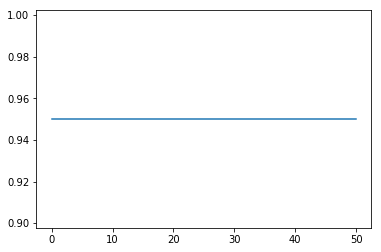

In [243]:
%%time
sim_user_abx()

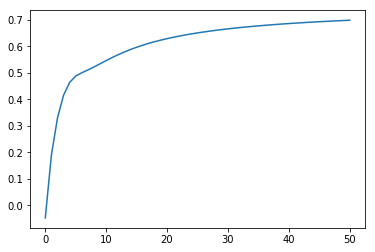

In [286]:
plt.plot(np.linspace(0,50,51),birthprob(np.linspace(0,50,51),1000,.95,.8,4)-deathprob(300,np.linspace(0,50,51),100,.05,1))

In [257]:
def deathprob

<function __main__.deathprob(d, m, s, p0, n)>

In [371]:
def deathprob(d,m,s, a,n,b): 
    y= (a-s)*(d**n/(d**n+(b*m)*((s+a)/s))) +s
    return y


In [372]:
t= np.linspace(0,50,51)

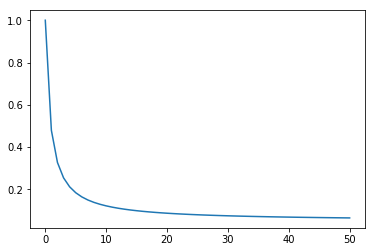

In [377]:
plt.plot(t,deathprob(3,t,.05,1,.5,.1))

In [370]:
deathprob(3,1000000,.05,1,.5)


0.05000007835467293